In [1]:
# Preparation steps for fastGWA

## 1. Create GRM (Done)

In [ ]:
%%bash
# chr=$1
# vcf=/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_sample_vcfs/subset_chr${chr}.dose.vcf.gz

# Only include SNPs with MAF>0.01 and imputation R2>0.8
# bcftools view -i 'INFO/MAF>0.01 & INFO/R2>0.9' ${vcf} > out

# Exclude HLA region
plink --bfile /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_sample_plink_preimpute/lipidomic_subset \
--exclude HLA_snps.txt \
--make-bed --out lipidomic_subset_for_grm

In [ ]:
%%bash
# Calcuate GRM
bfile=/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_GRM/lipidomic_subset_for_grm
gcta64 --bfile ${bfile} --make-grm --thread-num 32 --out lipidomic_grm

# Make a sparse GRM from the full-dense GRM
gcta64 --grm /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_GRM/lipidomic_grm \
--make-bK-sparse 0.05 --out /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_GRM/lipidomic_sp_grm

In [ ]:
'''
%%bash
# or, creare sparse GRM directly
bfile=/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_sample_plink_preimpute/lipidomic_subset
gcta64 --bfile ${bfile} \
--make-grm --sparse-cutoff 0.05 --threads 10 \
--out /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_GRM/grm
'''

## 2. Prepare covariate file
1. Model used:
    * trait ~ SNP + sex + age + age2 + PC1-5 + BMI + T2D + statin + GRM

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('/data100t1/home/wanying/lab_code/utils/')
from rank_based_inverse_normal_transformation import inverse_normal_transformation

import datetime
print('Last run:', datetime.datetime.now().strftime('%Y-%m-%d'))

Last run: 2023-03-02


Text(0, 0.5, 'Variance explained')

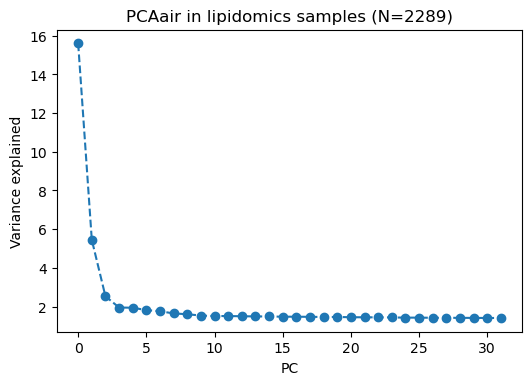

In [2]:
# Already run PCair in R
# Check scree plot
fn_pca_var = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_pca/CCHC_PCair.values.txt'
df_pca_var = pd.read_csv(fn_pca_var, sep='\t', header=None)
fig_pca, ax_pca = plt.subplots(figsize=(6,4), dpi=100)
ax_pca.plot(df_pca_var[1], ls='--', marker='o')
ax_pca.set_title('PCAair in lipidomics samples (N=2289)')
ax_pca.set_xlabel('PC')
ax_pca.set_ylabel('Variance explained')

In [3]:
# Load phenotype file
print('# Load phenotype file:')
fn_pheno = '/data100t1/share/CCHC/phenotypes/0123/cchc_phenotypes_0123.txt'
cols_to_use = ['RRID', 'LABID', 'VISIT', 'INTERVIEW_DATE', 'AGE_AT_VISIT', 'GENDER', 'CHOL1', 'trig', 'hdlc', 'ldlcalc',
               'ADA2010_Cat', 'ADA2010_DM', 'BMI1'] + [f'MED{i}' for i in range(1,11)]
df_pheno = pd.read_csv(fn_pheno, sep='|', dtype='str')[cols_to_use]
for col in cols_to_use[4:13]:
    df_pheno[col] = pd.to_numeric(df_pheno[col], errors='coerce')
print(df_pheno.shape)
display(df_pheno.head(3))

print('\n# Load pca file:')
fn_pca = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_pca/CCHC_PCair.vectors'
df_pca = pd.read_csv(fn_pca, sep='\t', header=None).rename(columns={0:'genotype_ID', 1:'PC1', 2:'PC2', 3:'PC3', 4:'PC4', 5:'PC5'})
print(' - Load id mapping file:', end='')
df_id_mapping = pd.read_csv('/data100t1/home/wanying/CCHC/doc/samples_IDs/202211_merged_RNA_lipid_protein_genotype_mapping_and_availability.txt',
                            sep='\t').drop_duplicates(subset='lipidomic').dropna(subset='lipidomic')
print(df_id_mapping.shape)
df_pca = df_id_mapping[['RRID', 'LABID', 'genotype_ID']].merge(df_pca[['genotype_ID', 'PC1', 'PC2',
                                                                          'PC3', 'PC4', 'PC5']], on='genotype_ID')
print('PCA:',df_pca.shape)
display(df_pca.head(3))


# Load phenotype file:
(10249, 23)


,RRID,LABID,VISIT,INTERVIEW_DATE,AGE_AT_VISIT,GENDER,CHOL1,trig,hdlc,ldlcalc,...,MED1,MED2,MED3,MED4,MED5,MED6,MED7,MED8,MED9,MED10
0,BD0001,BD4001,1.0,2004-01-29,40.0,2.0,189.0,115.0,45.0,121.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BD0001,5Y0002,2.0,2008-10-08,30.0,2.0,212.0,147.0,42.0,140.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BD0002,BD4002,1.0,2004-01-30,56.0,2.0,192.0,173.0,49.0,108.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



# Load pca file:
 - Load id mapping file:(2495, 6)
PCA: (2361, 8)


,RRID,LABID,genotype_ID,PC1,PC2,PC3,PC4,PC5
0,BD0009,10Y0308,BD0009_BD4009,-0.018380,-0.068916,0.005953,0.003658,-0.010963
1,BD0010,10Y0021,BD0010_BD4010,-0.007637,-0.007147,-0.003714,0.000468,-0.000608
2,BD0058,10Y0246,BD0058_BD4058,-0.021033,-0.005653,0.006732,0.001619,0.001991


In [4]:
# Merge pca with phenotype file
df_pheno_pca = df_pheno.merge(df_pca, on=['RRID', 'LABID'])
# Only keep the most rescent visit of duplicated samples
df_pheno_pca['VISIT'] = pd.to_numeric(df_pheno_pca['VISIT'], errors='coerce')
df_pheno_pca.sort_values(by=['RRID', 'VISIT'], inplace=True)
df_pheno_pca.drop_duplicates(subset='RRID', keep='last', inplace=True)

# Check if subject is on statins

df_pheno_pca['MEDS'] = df_pheno_pca['MED1'].replace(to_replace=np.nan, value='')
for i in range(2, 11):
    df_pheno_pca['MEDS'] = df_pheno_pca['MEDS'] + ', ' + df_pheno_pca[f'MED{i}'].replace(to_replace=np.nan, value='')
    
def any_statin(med):
    # Check if MEDS column has any statin
    lst_statin = ['statin', 'Lipitor', 'Lescol', 'Altoprev','Livalo', 'Zypitamag', 'Pravachol', 'Crestor', 'Ezallor', 'Zocor']
    if med == ', , , , , , , , , ':
        return np.nan
    else:
        for m in lst_statin:
            if m.upper() in med.upper():
                return 1
    return 0

df_pheno_pca['ON_STATIN'] = df_pheno_pca['MEDS'].apply(any_statin)

# Save for future use
output_fn = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipidomics_samples_covariates.txt'
if not os.path.isfile(output_fn):
    df_pheno_pca.to_csv(output_fn, sep='\t', index=False)
else:
    print(f'# File already exists: {output_fn}\n# Skip saving')

# File already exists: /data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipidomics_samples_covariates.txt
# Skip saving


In [5]:
df_pca.head()

,RRID,LABID,genotype_ID,PC1,PC2,PC3,PC4,PC5
0,BD0009,10Y0308,BD0009_BD4009,-0.018380,-0.068916,0.005953,0.003658,-0.010963
1,BD0010,10Y0021,BD0010_BD4010,-0.007637,-0.007147,-0.003714,0.000468,-0.000608
2,BD0058,10Y0246,BD0058_BD4058,-0.021033,-0.005653,0.006732,0.001619,0.001991
3,BD0231,10Y0261,BD0231_BD4231,-0.026401,-0.001750,0.002409,-0.002557,0.002853
4,BD0237,10Y0245,BD0237_BD04237,-0.037821,0.011431,0.002255,0.001790,-0.001294


Text(0.5, 0, 'Number of samples per RRID')

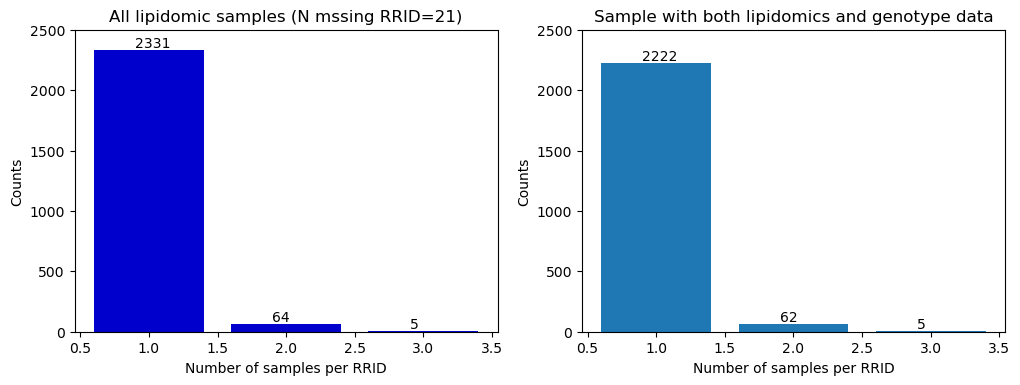

In [4]:
# There are duplicate RRIDs, check the number
fig_lip, ax_lip = plt.subplots(dpi=100, figsize=(12, 4), ncols=2)
# All lipidomic samples
x = list(df_id_mapping.dropna(subset='RRID').groupby(by='RRID').count().groupby(by='LABID').count().index)
height = list(df_id_mapping.dropna(subset='RRID').groupby(by='RRID').count().groupby(by='LABID').count()['genotype_ID'])
missing_rris = len(df_id_mapping[df_id_mapping['RRID'].isna()])
ax_lip[0].bar(x, height, color='mediumblue')
ax_lip[0].set_ylim(top=2500)
for i in range(len(x)):
    ax_lip[0].annotate(text=str(height[i]), xy=[x[i]-0.1, height[i]+25])
ax_lip[0].set_title(f'All lipidomic samples (N mssing RRID={missing_rris})')
ax_lip[0].set_ylabel('Counts')
ax_lip[0].set_xlabel('Number of samples per RRID')

# Lipidomic samples with genotype data
x = df_pca.groupby(by='RRID').count().groupby(by='LABID').count().index
height = list(df_pca.groupby(by='RRID').count().sort_values(by='LABID').groupby(by='LABID').count()['genotype_ID'])
ax_lip[1].bar(x, height)
ax_lip[1].set_ylim(top=2500)
for i in range(len(x)):
    ax_lip[1].annotate(text=str(height[i]), xy=[x[i]-0.1, height[i]+25])
ax_lip[1].set_title('Sample with both lipidomics and genotype data')
ax_lip[1].set_ylabel('Counts')
ax_lip[1].set_xlabel('Number of samples per RRID')

In [5]:
df_id_mapping[df_id_mapping['RRID'].isna()].shape

(21, 6)

In [13]:
# Save lipidomic samples without RRID, ask Miryoung if she has records
df_id_mapping.head()

,RRID,LABID,genotype_ID,RNAseq,lipidomic,proteomic
9,BD0009,10Y0308,BD0009_BD4009,10Y0308,10Y0308,NaN
11,BD0010,10Y0021,BD0010_BD4010,10Y0021,10Y0021,NaN
94,BD0058,10Y0246,BD0058_BD4058,NaN,10Y0246,NaN
378,BD0231,10Y0261,BD0231_BD4231,NaN,10Y0261,NaN
405,BD0237,10Y0245,BD0237_BD04237,10Y0245,10Y0245,10Y0245


## 3. INV lipidomic data

In [31]:
dir_lipidomic = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_measures/'
df_lip_class = pd.read_csv(dir_lipidomic+'lipid_classes.txt', sep='\t')
df_lip_species = pd.read_csv(dir_lipidomic+'lipid_species.txt', sep='\t')
df_lip_class.rename(columns={'Sample ID':'LABID'}, inplace=True)
df_lip_species.rename(columns={'Sample ID':'LABID'}, inplace=True)

print(f'# Load lipidomic class {df_lip_class.shape}')
display(df_lip_class.head(2))
print(f'# Load lipidomic species {df_lip_species.shape}')
display(df_lip_species.head(2))

# Load lipidomic class (2499, 51)


,MS Label,LABID,Sph,S1P,dhCer,Cer(d),Cer(m),C1P,HexCer,Hex2Cer,...,AC-OH,BA,DG,DG(O),TG(SIM),TG [NL],TG(O),TG(O) [NL],Ubiquinone,OxSpecies
0,CCHC_01-017_S_E01-V003_HA0104,HA0104,254.999498,1691.313342,333.217015,17571.726796,876.402934,1.202406,3879.184176,4318.699446,...,23.335873,389.626196,232063.979917,2541.683742,8.232466e+06,3.183823e+06,3599.819767,3776.402567,4542.840802,9203.204648
1,CCHC_01-018_S_E01-V004_BD6685,BD6685,516.276146,1887.402891,268.319039,11111.877478,488.231999,2.449349,3097.045926,4471.714009,...,18.162453,591.413276,90023.916254,2067.929498,4.147333e+06,1.768928e+06,1632.327185,1686.173964,1963.553775,6774.019402


# Load lipidomic species (2499, 832)


,MS Label,LABID,Sph(d18:1),Sph(d18:2),S1P(d16:1),S1P(d18:0),S1P(d18:1),S1P(d18:2),dhCer(d18:0/16:0),dhCer(d18:0/18:0),...,TG(O-54:4) [NL-18:2],Ubiquinone,CE(18:2) [+OH],CE(20:4) [+OH],LPC(18:2) [+OH],LPC(20:4) [+OH],LPC(22:6) [+OH],PC(34:2) [+OH],PC(36:4) [+OH],PC(38:6) [+OH]
0,CCHC_01-017_S_E01-V003_HA0104,HA0104,218.972291,36.027206,101.913318,131.658287,1153.691330,304.050408,20.413681,6.433955,...,85.790374,4542.840802,7084.104534,1926.531394,11.157690,29.764967,9.233837,8.428339,116.364699,17.619188
1,CCHC_01-018_S_E01-V004_BD6685,BD6685,438.511461,77.764685,101.187911,199.556423,1398.262469,188.396088,18.946864,4.173933,...,35.645512,1963.553775,5579.135756,940.768454,39.103876,83.618501,29.565119,14.366459,74.550387,12.910849


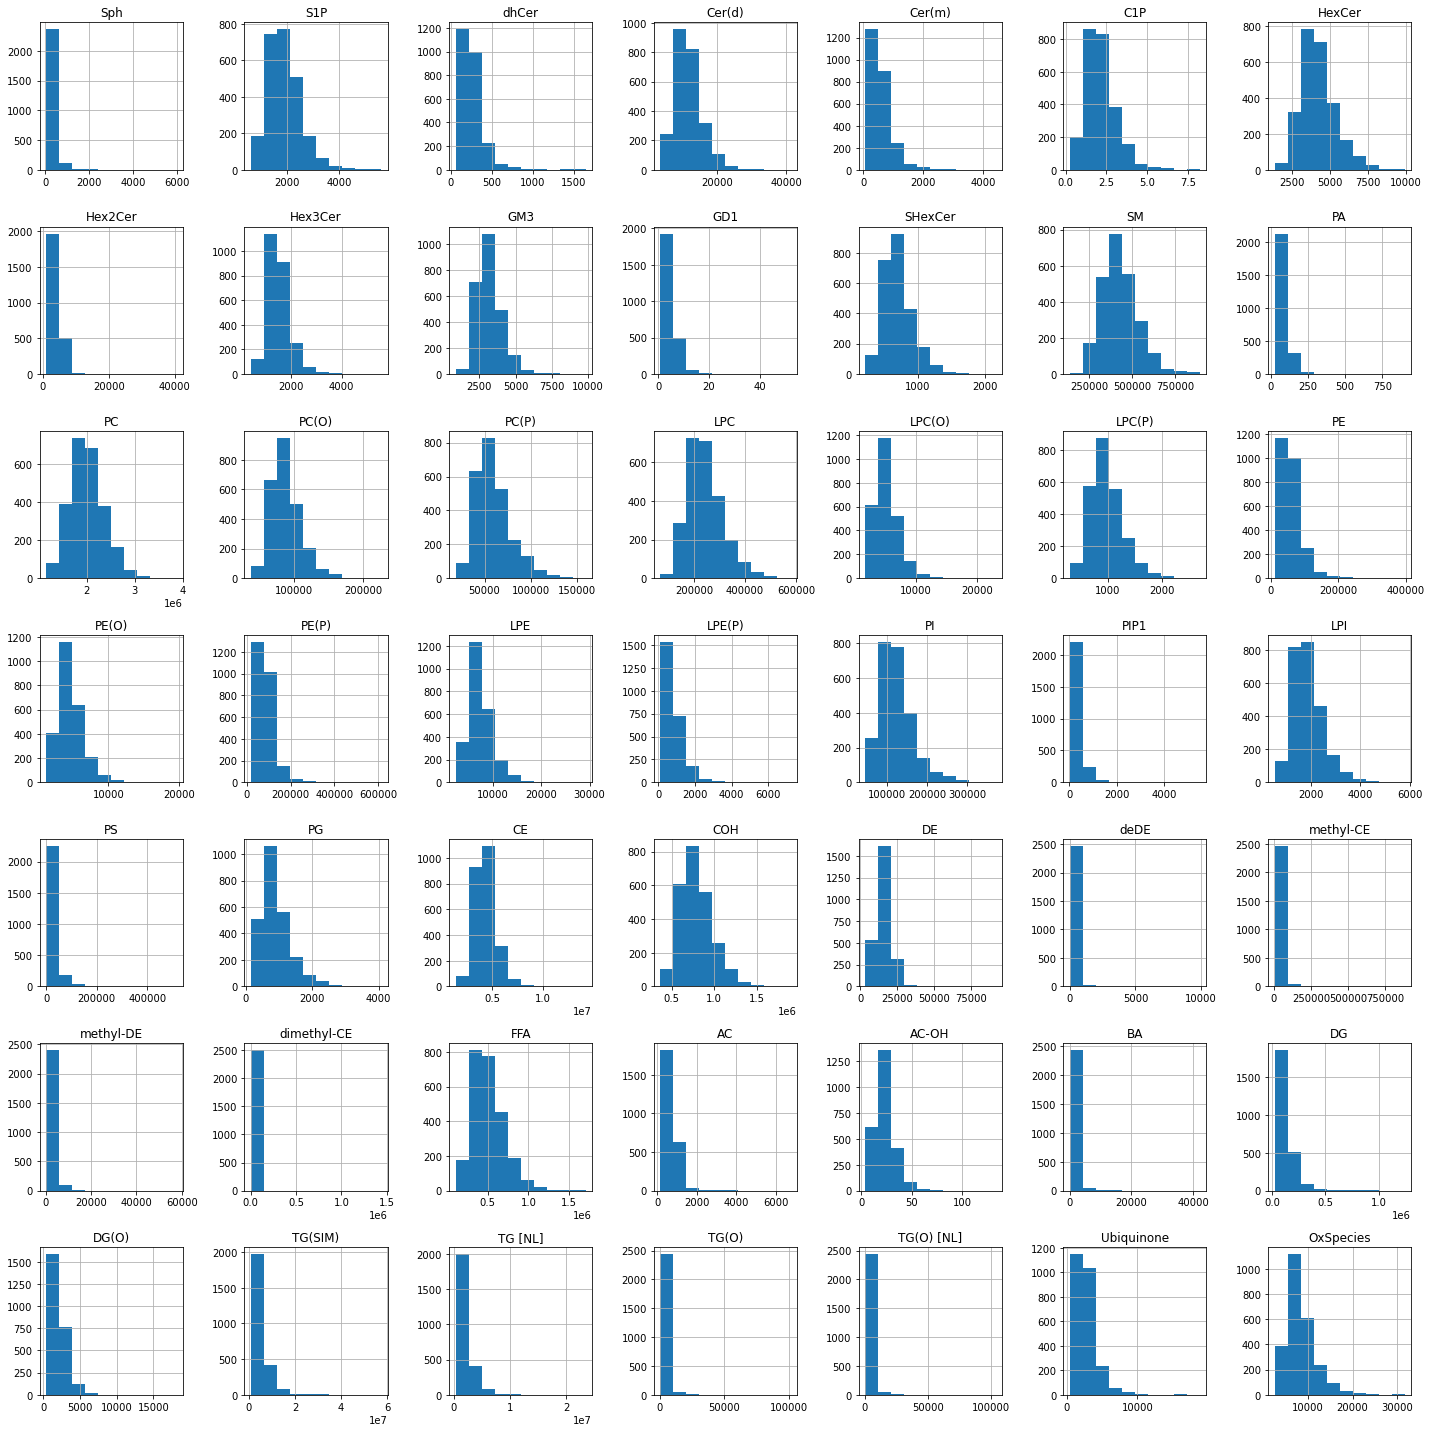

In [8]:
ax_lip_class = df_lip_class.hist(figsize=(20,20))
plt.tight_layout()

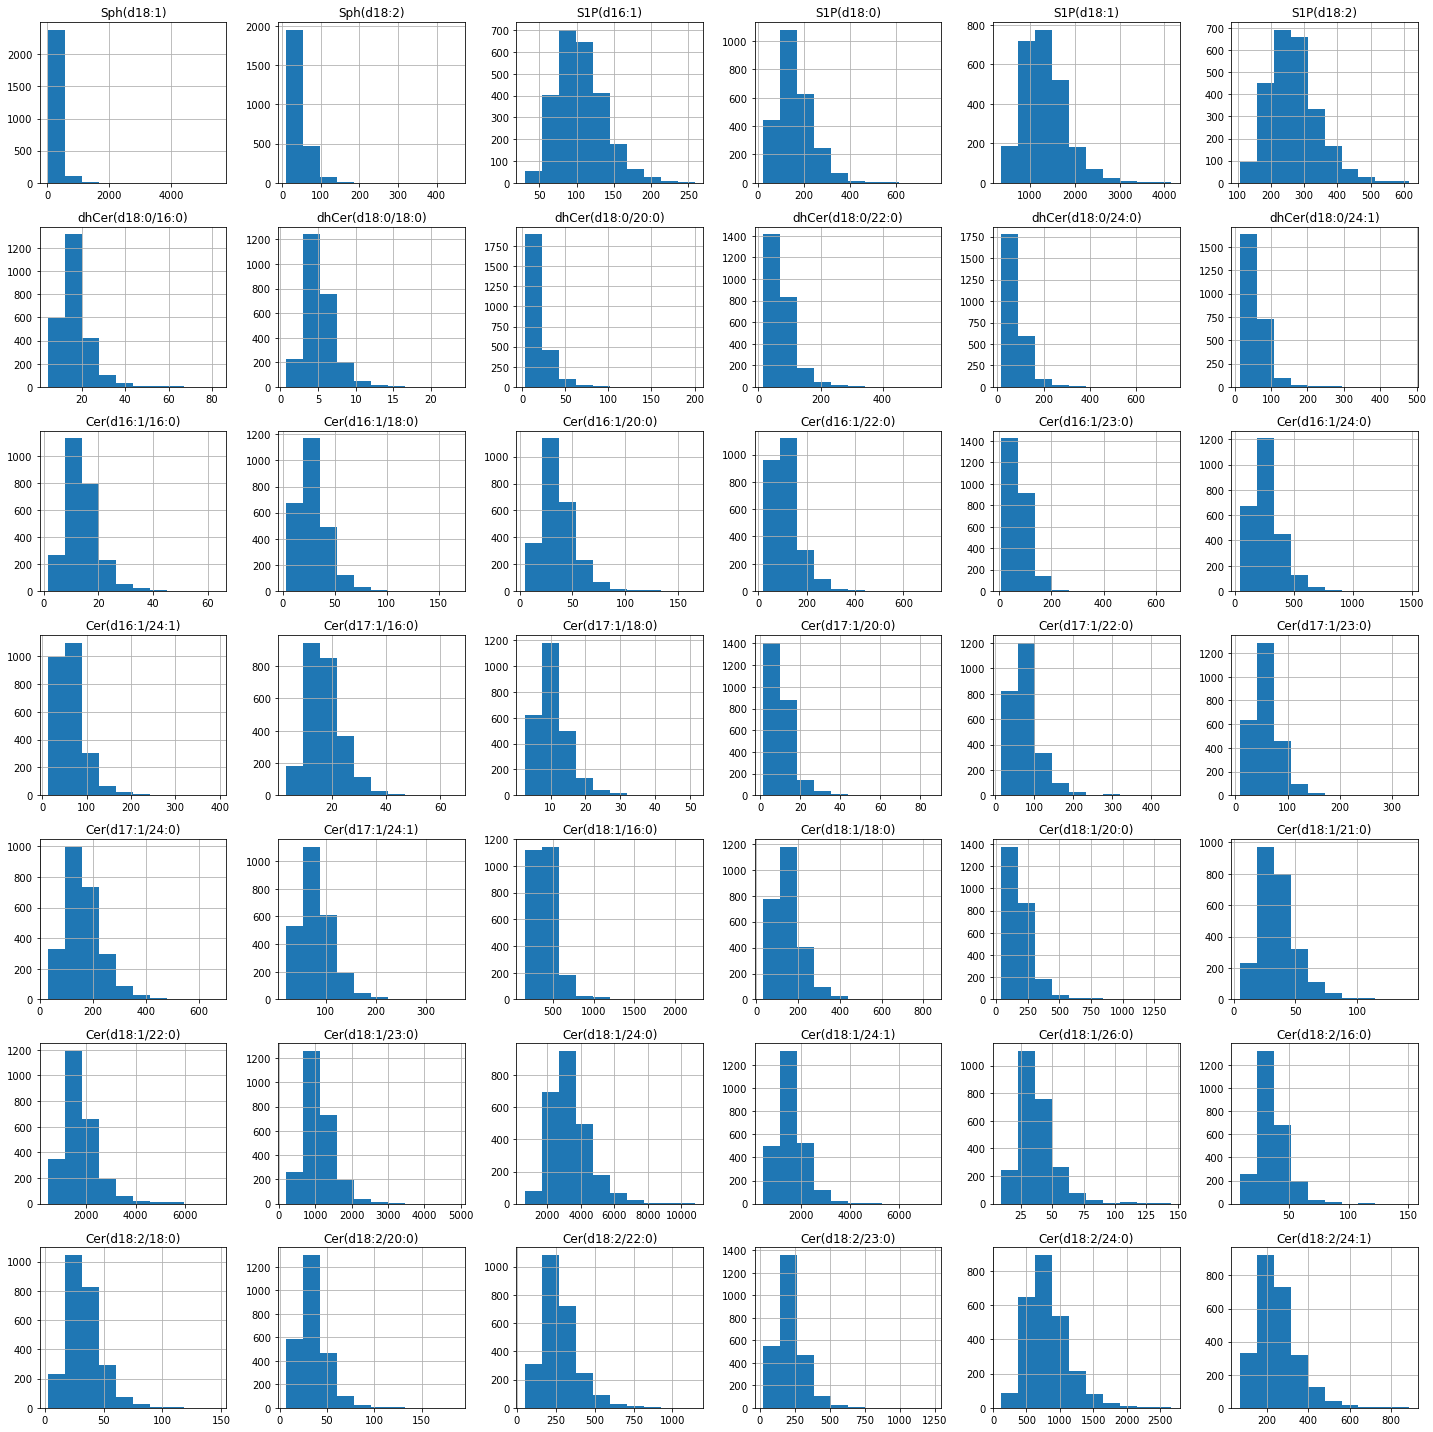

In [9]:
ax_lip_species = df_lip_species.iloc[:, :44].hist(figsize=(20,20))
plt.tight_layout()

In [10]:
# There are 3 duplicated samples
print('# Duplicated samples in lipid class')
df_dup_lip_class = df_lip_class[df_lip_class['LABID'].duplicated(keep=False)].sort_values('LABID')
display(df_dup_lip_class.sort_values('LABID'))
print('\n# Duplicated samples in lipid species')
df_dup_lip_species = df_lip_species[df_lip_species['LABID'].duplicated(keep=False)]
display(df_dup_lip_species.sort_values('LABID'))

# Duplicated samples in lipid class


,MS Label,LABID,Sph,S1P,dhCer,Cer(d),Cer(m),C1P,HexCer,Hex2Cer,...,AC-OH,BA,DG,DG(O),TG(SIM),TG [NL],TG(O),TG(O) [NL],Ubiquinone,OxSpecies
768,CCHC_02-442_S_E02-V389_BD6766,BD6766,208.316838,2308.706858,339.778881,10645.840577,713.161636,1.670486,3654.419104,5398.325272,...,21.619427,804.752285,173837.315749,1442.529374,7.633754e+06,2.847492e+06,2636.855584,2915.926696,3267.322560,5378.539929
1511,CCHC_04-332_S_E04-V289_BD6766,BD6766,453.409126,2215.325153,187.106361,8377.853696,232.232667,1.669788,3036.869277,3794.860682,...,23.228889,675.231652,66189.499109,1652.777290,2.743884e+06,1.105694e+06,1177.661882,1330.889006,1855.457495,7000.010451
354,CCHC_01-445_S_E01-V392_BD6767,BD6767,438.862450,2293.925033,449.285261,15872.230760,1061.834538,1.917350,2678.090839,6322.741776,...,35.199079,1692.588965,135555.213173,1770.405039,5.942661e+06,2.193348e+06,1838.230777,1967.898362,2773.993646,6527.524494
1481,CCHC_04-294_S_E04-V255_BD6767,BD6767,179.961660,1912.529266,117.027007,8626.929329,289.765030,3.090769,3639.576426,3911.452661,...,26.737965,554.620695,47364.463989,1872.889188,2.018345e+06,7.966757e+05,1386.653562,1446.834559,1771.302656,5821.127453
373,CCHC_01-469_S_E01-V414_BD6768,BD6768,632.264466,1955.480696,251.037404,12361.503418,548.770481,2.194238,3279.869369,4290.242039,...,16.240625,1027.643640,116835.673915,2981.056126,6.218075e+06,2.359051e+06,2016.553376,2189.216231,4542.560701,9898.166477
894,CCHC_03-090_S_E03-V069_BD6768,BD6768,458.380388,2778.032630,400.749706,9676.081415,541.983297,3.793039,3550.135581,8031.003983,...,46.792293,2028.840573,54772.557172,1161.756534,1.836205e+06,7.359421e+05,1615.226368,1698.806300,2401.532967,9353.760350
1615,CCHC_04-457_S_E04-V403_BD6768,BD6768,215.951481,2328.818727,208.087674,13514.021515,301.998789,4.751872,5075.242213,4213.531207,...,29.063290,1070.172877,53895.694174,1287.047543,2.458434e+06,9.208182e+05,2671.424597,2842.739252,2007.513421,8905.799961



# Duplicated samples in lipid species


,MS Label,LABID,Sph(d18:1),Sph(d18:2),S1P(d16:1),S1P(d18:0),S1P(d18:1),S1P(d18:2),dhCer(d18:0/16:0),dhCer(d18:0/18:0),...,TG(O-54:4) [NL-18:2],Ubiquinone,CE(18:2) [+OH],CE(20:4) [+OH],LPC(18:2) [+OH],LPC(20:4) [+OH],LPC(22:6) [+OH],PC(34:2) [+OH],PC(36:4) [+OH],PC(38:6) [+OH]
768,CCHC_02-442_S_E02-V389_BD6766,BD6766,170.308839,38.007999,106.052911,159.576082,1760.174727,282.903138,22.817400,7.635398,...,109.014767,3267.322560,4300.709005,821.185748,21.684329,39.516464,12.186521,16.545088,138.164408,28.548367
1511,CCHC_04-332_S_E04-V289_BD6766,BD6766,383.332749,70.076377,80.287629,255.541928,1628.447076,251.048519,12.535177,5.214205,...,40.189250,1855.457495,5899.743694,814.554925,37.600974,117.755003,35.114974,10.841913,70.283558,14.115409
354,CCHC_01-445_S_E01-V392_BD6767,BD6767,375.481097,63.381353,115.988622,207.018117,1648.914497,322.003797,27.310452,8.370076,...,67.626419,2773.993646,5201.847677,1054.390735,37.100592,53.942848,20.033566,12.329371,119.642964,28.236742
1481,CCHC_04-294_S_E04-V255_BD6767,BD6767,134.741717,45.219943,79.442826,185.159845,1353.553933,294.372663,9.760499,5.083516,...,41.325916,1771.302656,4420.992097,1162.979369,20.572329,78.877771,19.491502,11.795429,92.655642,13.763314
373,CCHC_01-469_S_E01-V414_BD6768,BD6768,536.609182,95.655284,116.496463,207.992692,1424.671900,206.319641,14.844684,3.484987,...,79.762669,4542.560701,8699.181746,825.144713,59.127015,161.759307,58.425663,21.952470,61.311478,11.264084
894,CCHC_03-090_S_E03-V069_BD6768,BD6768,390.616543,67.763845,83.895553,180.374467,2115.614625,398.147984,23.270751,8.551527,...,52.647290,2401.532967,6930.198270,1929.768496,34.614364,188.753399,35.393858,6.226163,200.361538,28.444261
1615,CCHC_04-457_S_E04-V403_BD6768,BD6768,177.150654,38.800827,161.421577,206.370940,1631.177080,329.849129,17.330968,7.185307,...,61.851317,2007.513421,7371.004274,1293.558685,28.399411,50.305613,27.583520,9.652816,93.627736,31.667906


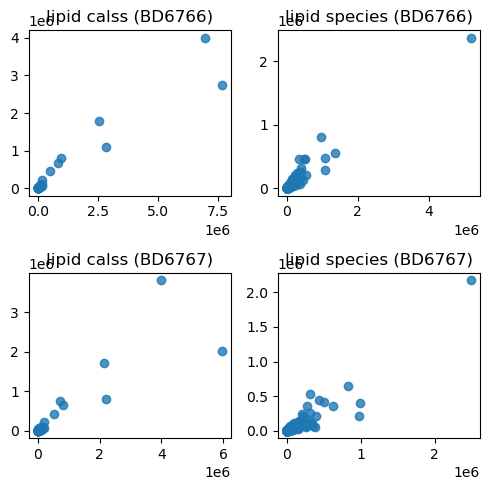

In [18]:
# Sample BD6768 does not have genotype data, so only check BD6766 and BD6767
# Compare measures from two entries
fig_dup, ax_dup = plt.subplots(nrows=2, ncols=2, figsize=(5, 5), dpi=100)

# Plot BD6766
df_lip_class_BD6766 = df_dup_lip_class[df_dup_lip_class['LABID']=='BD6766']
ax_dup[0,0].plot(df_lip_class_BD6766.iloc[0, 2:], df_lip_class_BD6766.iloc[1, 2:], ls='', marker='o', alpha=0.8)
ax_dup[0,0].set_title('lipid calss (BD6766)')
df_lip_species_BD6766 = df_dup_lip_species[df_dup_lip_species['LABID']=='BD6766']
ax_dup[0,1].plot(df_lip_species_BD6766.iloc[0, 2:], df_lip_species_BD6766.iloc[1, 2:], ls='', marker='o', alpha=0.8)
ax_dup[0,1].set_title('lipid species (BD6766)')

# Plot BD6766
df_lip_class_BD6767 = df_dup_lip_class[df_dup_lip_class['LABID']=='BD6767']
ax_dup[1,0].plot(df_lip_class_BD6767.iloc[0, 2:], df_lip_class_BD6767.iloc[1, 2:], ls='', marker='o', alpha=0.8)
ax_dup[1,0].set_title('lipid calss (BD6767)')
df_lip_species_BD6767 = df_dup_lip_species[df_dup_lip_species['LABID']=='BD6767']
ax_dup[1,1].plot(df_lip_species_BD6767.iloc[0, 2:], df_lip_species_BD6767.iloc[1, 2:], ls='', marker='o', alpha=0.8)
ax_dup[1,1].set_title('lipid species (BD6767)')

fig_dup.tight_layout()

In [32]:
# Redomove duplicated sample, only keep one of them (the first one)
df_lip_class.drop_duplicates(subset='LABID', inplace=True)
df_lip_species.drop_duplicates(subset='LABID', inplace=True)

# INV transformation of measurements
for col in df_lip_class.columns[2:]:
    df_lip_class[col] = inverse_normal_transformation(df_lip_class[col])
    
for col in df_lip_species.columns[2:]:
    df_lip_species[col] = inverse_normal_transformation(df_lip_species[col])
    
# Merge lipidomic measures with other covariates
df_pheno_pca_lip_class = df_pheno_pca.merge(df_lip_class, on='LABID')
df_pheno_pca_lip_species = df_pheno_pca.merge(df_lip_species, on='LABID')

# Save files
output_lip_class = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipid_class_INVed_covar.txt'
if not os.path.isfile(output_lip_class):
    df_pheno_pca_lip_class.to_csv(output_lip_class, sep='\t', index=False)
else:
    print(f'# File already exists, skip saving: {output_lip_class}')
    
output_lip_species = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipid_species_INVed_covar.txt'
if not os.path.isfile(output_lip_species):
    df_pheno_pca_lip_species.to_csv(output_lip_species, sep='\t', index=False)
else:
    print(f'# File already exists, skip saving: {output_lip_species}')

### 3.1 Check demographics of valid lipidomic samples

In [5]:
fn='/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipidomics_samples_covariates.txt'
df_valid_sample = pd.read_csv(fn, sep='\t')
df_valid_sample.head()

,RRID,LABID,VISIT,INTERVIEW_DATE,AGE_AT_VISIT,GENDER,CHOL1,trig,hdlc,ldlcalc,...,MED9,MED10,genotype_ID,PC1,PC2,PC3,PC4,PC5,MEDS,ON_STATIN
0,BD0009,10Y0308,3.0,2018-02-07,56.0,1.0,180.0,62.0,48.0,120.0,...,NaN,NaN,BD0009_BD4009,-0.018380,-0.068916,0.005953,0.003658,-0.010963,"ARDOSONS 25 MG, SIMI FLEX TRIN, , , , , , , ,",0.0
1,BD0010,10Y0021,3.0,2014-08-12,49.0,2.0,152.0,79.0,56.0,80.0,...,NaN,NaN,BD0010_BD4010,-0.007637,-0.007147,-0.003714,0.000468,-0.000608,", , , , , , , , ,",NaN
2,BD0058,10Y0246,3.0,2017-04-24,48.0,2.0,180.0,133.0,39.0,114.0,...,NaN,NaN,BD0058_BD4058,-0.021033,-0.005653,0.006732,0.001619,0.001991,", , , , , , , , ,",NaN
3,BD0231,10Y0261,3.0,2017-06-14,60.0,2.0,142.0,160.0,49.0,61.0,...,NaN,NaN,BD0231_BD4231,-0.026401,-0.001750,0.002409,-0.002557,0.002853,", , , , , , , , ,",NaN
4,BD0237,10Y0245,3.0,2017-04-19,57.0,2.0,197.0,108.0,57.0,118.0,...,NaN,NaN,BD0237_BD04237,-0.037821,0.011431,0.002255,0.001790,-0.001294,", , , , , , , , ,",NaN


In [12]:
df_valid_sample.describe()

,VISIT,AGE_AT_VISIT,GENDER,CHOL1,trig,hdlc,ldlcalc,ADA2010_Cat,ADA2010_DM,BMI1,PC1,PC2,PC3,PC4,PC5,ON_STATIN
count,2289.000000,2287.000000,2289.000000,2279.000000,2281.000000,2280.000000,2241.000000,2248.00000,2233.000000,2096.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,888.000000
mean,1.216252,43.223874,1.622106,177.291049,143.453748,47.370044,102.350424,1.79226,0.229288,31.111927,-0.000542,0.000254,-0.000574,-0.000016,-0.000018,0.262387
std,1.246315,18.125177,0.484967,38.665798,103.913264,13.224330,34.338672,0.78764,0.420469,6.883688,0.023076,0.021523,0.022382,0.020946,0.020956,0.440180
min,1.000000,8.000000,1.000000,59.000000,28.000000,0.000000,16.000000,1.00000,0.000000,15.900000,-0.073318,-0.515505,-0.101738,-0.767519,-0.776817,0.000000
25%,1.000000,28.500000,1.000000,150.000000,85.000000,39.000000,79.000000,1.00000,0.000000,26.500000,-0.015746,-0.002738,-0.010534,-0.002091,-0.002247,0.000000
50%,1.000000,44.000000,2.000000,175.000000,119.000000,46.000000,100.000000,2.00000,0.000000,30.100000,-0.003148,0.001738,0.001031,0.000047,0.000102,0.000000
75%,1.000000,58.000000,2.000000,201.000000,165.000000,54.000000,123.000000,2.00000,0.000000,34.800000,0.011952,0.006085,0.008442,0.002074,0.002448,1.000000
max,17.000000,90.000000,2.000000,418.000000,1429.000000,248.000000,632.000000,3.00000,1.000000,82.600000,0.068349,0.026893,0.107742,0.589526,0.538211,1.000000


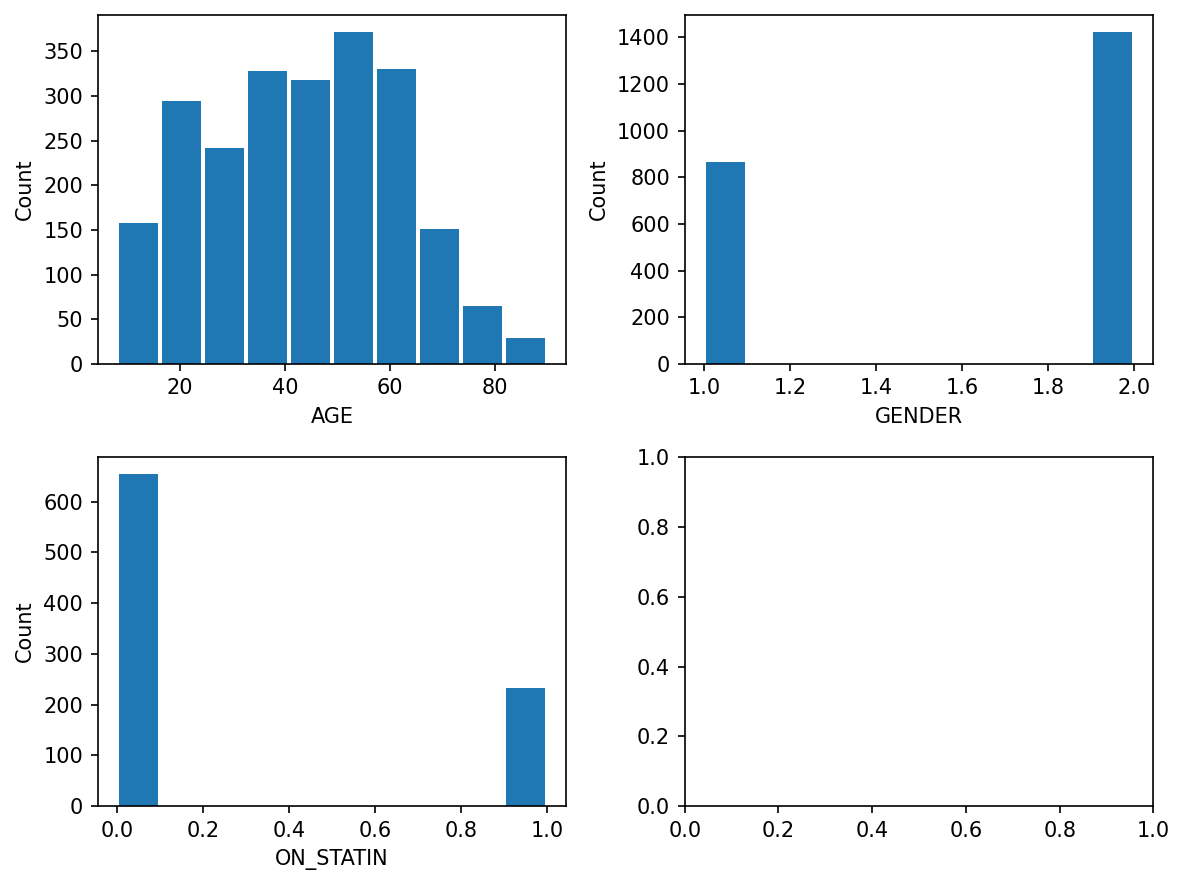

In [11]:
fig_dem, ax_dem = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), dpi=150)

ax_dem[0,0].hist(df_valid_sample['AGE_AT_VISIT'], rwidth=0.9)
ax_dem[0,0].set_xlabel('AGE')
ax_dem[0,0].set_ylabel('Count')

ax_dem[0,1].hist(df_valid_sample['GENDER'], rwidth=0.9)
ax_dem[0,1].set_xlabel('GENDER')
ax_dem[0,1].set_ylabel('Count')

ax_dem[1,0].hist(df_valid_sample['ON_STATIN'], rwidth=0.9)
ax_dem[1,0].set_xlabel('ON_STATIN')
ax_dem[1,0].set_ylabel('Count')

fig_dem.tight_layout()

## 4. Reformat files
Need input files for --pheno, --covar and --qcovar

https://yanglab.westlake.edu.cn/software/gcta/#GREMLanalysis
* ```--pheno```: Input phenotype data from a plain text file. If the phenotypic value is coded as 0 or 1, then it will be recognized as a case-control study (0 for controls and 1 for cases). Missing value should be represented by "-9" or "NA".

    Input file format: (no header line; columns are family ID, individual ID and phenotypes)\
    011       0101    0.98\
    012       0102    -0.76\
    013       0103    -0.06

* ```--covar```: Input discrete covariates from a plain text file.
    Input file format: (no header line; columns are family ID, individual ID and discrete covariates)
* ```--qcovar```: Input quantitative covariates from a plain text file, e.g. test.qcovar. Each quantitative covariate is recognized as a continuous variable.

    Input file format: (no header line; columns are family ID, individual ID and quantitative covariates)

In [114]:
dir_pheno_covar = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/'
fn_all_covar_lip_class = 'lipid_class_INVed_covar.txt'
fn_all_covar_lip_species = 'lipid_species_INVed_covar.txt'

df_all_covar_lip_class = pd.read_csv(dir_pheno_covar+fn_all_covar_lip_class, sep='\t')
df_id_fixed_lip_class['AGE2'] = df_id_fixed_lip_class['AGE_AT_VISIT']*df_id_fixed_lip_class['AGE_AT_VISIT']

df_all_covar_lip_species = pd.read_csv(dir_pheno_covar+fn_all_covar_lip_species, sep='\t')

# Load FID and IID from plink files
df_id = pd.read_csv('/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_sample_plink_imputed/plink_ids.txt',
                    sep='\t', header=None).rename(columns={0:'FID', 1:'IID'})

# FID_IID are mostly RRID_RRID, but a few (3) are RRID_LABID
lst_df_class = [df_id.merge(df_all_covar_lip_class, left_on='FID', right_on='RRID'),
          df_id.merge(df_all_covar_lip_class, left_on='FID', right_on='LABID')]
df_id_fixed_lip_class = pd.concat(lst_df_class)
df_id_fixed_lip_class = df_id.merge(df_id_fixed_lip_class, on=['FID', 'IID']) # Make sample order the same as in plink genotypo file
df_id_fixed_lip_class['AGE2'] = df_id_fixed_lip_class['AGE_AT_VISIT']*df_id_fixed_lip_class['AGE_AT_VISIT']

lst_df_species = [df_id.merge(df_all_covar_lip_species, left_on='FID', right_on='RRID'),
          df_id.merge(df_all_covar_lip_species, left_on='FID', right_on='LABID')]
df_id_fixed_lip_species = pd.concat(lst_df_species)
df_id_fixed_lip_species = df_id.merge(df_id_fixed_lip_species, on=['FID', 'IID']) 

In [115]:
# Discrete covariates
cols_id = ['FID', 'IID']
cols_covar = ['GENDER', 'ADA2010_Cat', 'ON_STATIN']

# Quantiative covariates
cols_qcovar = ['AGE_AT_VISIT', 'AGE2', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'BMI1']

output_dir = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/'
df_id_fixed_lip_class[cols_id+cols_covar].to_csv(output_dir+'-'.join(cols_covar)+'.covar',
                                                 sep='\t', na_rep='NA', index=False, header=False)
df_id_fixed_lip_class[cols_id+cols_qcovar].to_csv(output_dir+'-'.join(cols_qcovar)+'.qcovar',
                                                 sep='\t', na_rep='NA', index=False, header=False)


In [131]:
start_indx = 34
cols_id = ['FID', 'IID']
output_dict = {'lip_class':'/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipid_class_pheno/', 
               'lip_species':'/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipid_species_pheno/'}

count = 0
print('# Save lipid class files')
for lip_class in df_id_fixed_lip_class.columns[start_indx:-1]:
    output_dir = output_dict['lip_class']
    output_fn = output_dir + lip_class.replace('/', '-').replace('(','-').replace(')','-').replace(' ','_')  + '.pheno'
    # print(f'{output_dir}{lip_class}.pheno')
    df_id_fixed_lip_class[cols_id+[lip_class]].to_csv(output_fn, sep='\t',
                                                      index=False, header=False, na_rep='NA')
    count += 1
    if count%5==0: print('.', end='', flush=True)

count = 0
print('\n# Save lipid class species')
for lip_species in df_id_fixed_lip_species.columns[start_indx:]:
    # lip_species = lip_species.replace('/', '-') # Some lipid species has /
    output_dir = output_dict['lip_species']
    output_fn = output_dir + lip_species.replace('/', '-').replace('(','-').replace(')','-').replace(' ','_')  + '.pheno'
    # print(f'{output_dir}{lip_species}.pheno')
    try:
        df_id_fixed_lip_species[cols_id+[lip_species]].to_csv(output_fn, sep='\t',
                                                              index=False, header=False, na_rep='NA')
    except:
        print('# Error saving:', output_fn)
    count += 1
    if count%5==0: print('.', end='', flush=True)
print('\n# DONE')


# Save lipid class files
.........
# Save lipid class species
......................................................................................................................................................................
# DONE


## 5. fastGWA

In [ ]:
# Convert VCF to plink
for i in range(1, 23):
    screen_cmd = f'screen -dmS chr{i}; screen -S chr{i} -X stuff '
    cmd = 'output=/data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_sample_plink_imputed/; plink --vcf '
    cmd = cmd + f'subset_chr{i}.dose.vcf.gz --make-bed --out ' + '${output}' + f'chr{i}'
    cmd = screen_cmd + '"' + cmd + '; exit\\n"'
    print(cmd+'\n')


In [ ]:
%%bash
# Format of --pheno, --qcovar and --covar can be found here:
# https://gcta.freeforums.net/thread/510/limit-on-qcovars-fastgwa
lipid=$1
gcta64 --mbfile /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_sample_plink_imputed/plink_files.txt \
--grm-sparse /data100t1/home/wanying/CCHC/lipidomics/input_docs/lipidomic_GRM/lipidomic_sp_grm \
--fastGWA-mlm \
--pheno /data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipid_class_pheno/${lipid}.pheno \
--qcovar /data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/AGE_AT_VISIT-AGE2-PC1-PC2-PC3-PC4-PC5-BMI1.qcovar \
--covar /data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/GENDER.covar \
--save-fastGWA-mlm-residual \
--thread-num 16 \
--out /data100t1/home/wanying/CCHC/lipidomics/output/lip_class_GWAS/${lipid}

In [13]:
# Command to run GWAS in lipid classes
# Save to file
lip_class_dir = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipid_class_pheno'
fh = open('/data100t1/home/wanying/CCHC/lipidomics/code/vgi02_gwas_all.sh', 'w')
for lip_class in os.listdir(lip_class_dir):
    lip_class = lip_class.split('.')[0]
    cmd = f'./run_fastGWA_lip_class.sh {lip_class}'
    fh.write(cmd+'\n')
fh.close()

In [ ]:
# Command to run GWAS in lipid classes
# screen -dmS chr22; screen -S chr22 -X stuff "plink2 --vcf ../subset_chr22.dose.vcf.gz 'dosage'=DS --out subset_chr22;exit\n"
lip_class_dir = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipid_class_pheno'
for lip_class in os.listdir(lip_class_dir):
    lip_class = lip_class.split('.')[0]
    cmd = f'./run_fastGWA_lip_class.sh {lip_class}'
    cmd = f'screen -dmS {lip_class}; screen -S {lip_class} -X stuff "{cmd}; exit\\n"'
    print(cmd)
    
    

screen -dmS methyl-CE; screen -S methyl-CE -X stuff "./run_fastGWA_lip_class.sh methyl-CE; exit\n"

screen -dmS TG-SIM-; screen -S TG-SIM- -X stuff "./run_fastGWA_lip_class.sh TG-SIM-; exit\n"

screen -dmS PA; screen -S PA -X stuff "./run_fastGWA_lip_class.sh PA; exit\n"

screen -dmS LPC-O-; screen -S LPC-O- -X stuff "./run_fastGWA_lip_class.sh LPC-O-; exit\n"

screen -dmS AC-OH; screen -S AC-OH -X stuff "./run_fastGWA_lip_class.sh AC-OH; exit\n"

screen -dmS Cer-d-; screen -S Cer-d- -X stuff "./run_fastGWA_lip_class.sh Cer-d-; exit\n"

screen -dmS Cer-m-; screen -S Cer-m- -X stuff "./run_fastGWA_lip_class.sh Cer-m-; exit\n"

screen -dmS PC-O-; screen -S PC-O- -X stuff "./run_fastGWA_lip_class.sh PC-O-; exit\n"

screen -dmS PS; screen -S PS -X stuff "./run_fastGWA_lip_class.sh PS; exit\n"

screen -dmS LPC-P-; screen -S LPC-P- -X stuff "./run_fastGWA_lip_class.sh LPC-P-; exit\n"

screen -dmS COH; screen -S COH -X stuff "./run_fastGWA_lip_class.sh COH; exit\n"

screen -dmS Sph; screen -S

In [15]:
# Command to run GWAS in lipid species
# Save to file
lip_species_dir = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipid_species_pheno'
fh = open('/data100t1/home/wanying/CCHC/lipidomics/code/vgi02_gwas_all.sh', 'w')
for lip_species in os.listdir(lip_species_dir):
    lip_species = lip_species.split('.')[0]
    cmd = f'./run_fastGWA_lip_species.sh {lip_species}'
    fh.write(cmd+'\n')
fh.close()

In [ ]:
# Command to run GWAS in lipid species
lip_species_dir = '/data100t1/home/wanying/CCHC/lipidomics/input_docs/pheno_covar_files/lipid_species_pheno'
for lip_species in os.listdir(lip_species_dir):
    lip_species = lip_species.split('.')[0]
    cmd = f'./run_fastGWA_lip_species.sh {lip_species}'
    cmd = f'screen -dmS {lip_species}; screen -S {lip_species} -X stuff "{cmd}; exit\\n"'
    print(cmd)

ValueError: I/O operation on closed file.

## CMD to be run

In [9]:
cmd_str = '''
screen -dmS methyl-CE; screen -S methyl-CE -X stuff "./run_fastGWA_lip_class.sh methyl-CE; exit\n"
screen -dmS TG-SIM-; screen -S TG-SIM- -X stuff "./run_fastGWA_lip_class.sh TG-SIM-; exit\n"
screen -dmS PA; screen -S PA -X stuff "./run_fastGWA_lip_class.sh PA; exit\n"
screen -dmS LPC-O-; screen -S LPC-O- -X stuff "./run_fastGWA_lip_class.sh LPC-O-; exit\n"
screen -dmS AC-OH; screen -S AC-OH -X stuff "./run_fastGWA_lip_class.sh AC-OH; exit\n"
screen -dmS Cer-d-; screen -S Cer-d- -X stuff "./run_fastGWA_lip_class.sh Cer-d-; exit\n"
screen -dmS Cer-m-; screen -S Cer-m- -X stuff "./run_fastGWA_lip_class.sh Cer-m-; exit\n"
screen -dmS PC-O-; screen -S PC-O- -X stuff "./run_fastGWA_lip_class.sh PC-O-; exit\n"
screen -dmS PS; screen -S PS -X stuff "./run_fastGWA_lip_class.sh PS; exit\n"
screen -dmS LPC-P-; screen -S LPC-P- -X stuff "./run_fastGWA_lip_class.sh LPC-P-; exit\n"
screen -dmS COH; screen -S COH -X stuff "./run_fastGWA_lip_class.sh COH; exit\n"
screen -dmS Sph; screen -S Sph -X stuff "./run_fastGWA_lip_class.sh Sph; exit\n"
screen -dmS PE-O-; screen -S PE-O- -X stuff "./run_fastGWA_lip_class.sh PE-O-; exit\n"
screen -dmS dimethyl-CE; screen -S dimethyl-CE -X stuff "./run_fastGWA_lip_class.sh dimethyl-CE; exit\n"
screen -dmS LPE-P-; screen -S LPE-P- -X stuff "./run_fastGWA_lip_class.sh LPE-P-; exit\n"
screen -dmS C1P; screen -S C1P -X stuff "./run_fastGWA_lip_class.sh C1P; exit\n"
screen -dmS GM3; screen -S GM3 -X stuff "./run_fastGWA_lip_class.sh GM3; exit\n"
screen -dmS BA; screen -S BA -X stuff "./run_fastGWA_lip_class.sh BA; exit\n"
screen -dmS OxSpecies; screen -S OxSpecies -X stuff "./run_fastGWA_lip_class.sh OxSpecies; exit\n"
screen -dmS DG-O-; screen -S DG-O- -X stuff "./run_fastGWA_lip_class.sh DG-O-; exit\n"
screen -dmS TG-O-; screen -S TG-O- -X stuff "./run_fastGWA_lip_class.sh TG-O-; exit\n"
screen -dmS DG; screen -S DG -X stuff "./run_fastGWA_lip_class.sh DG; exit\n"
screen -dmS deDE; screen -S deDE -X stuff "./run_fastGWA_lip_class.sh deDE; exit\n"
screen -dmS CE; screen -S CE -X stuff "./run_fastGWA_lip_class.sh CE; exit\n"
screen -dmS SM; screen -S SM -X stuff "./run_fastGWA_lip_class.sh SM; exit\n"
screen -dmS FFA; screen -S FFA -X stuff "./run_fastGWA_lip_class.sh FFA; exit\n"
screen -dmS dhCer; screen -S dhCer -X stuff "./run_fastGWA_lip_class.sh dhCer; exit\n"
screen -dmS PC; screen -S PC -X stuff "./run_fastGWA_lip_class.sh PC; exit\n"
screen -dmS Hex3Cer; screen -S Hex3Cer -X stuff "./run_fastGWA_lip_class.sh Hex3Cer; exit\n"
screen -dmS PG; screen -S PG -X stuff "./run_fastGWA_lip_class.sh PG; exit\n"
screen -dmS TG-O-_[NL]; screen -S TG-O-_[NL] -X stuff "./run_fastGWA_lip_class.sh TG-O-_[NL]; exit\n"
screen -dmS PI; screen -S PI -X stuff "./run_fastGWA_lip_class.sh PI; exit\n"
screen -dmS TG_[NL]; screen -S TG_[NL] -X stuff "./run_fastGWA_lip_class.sh TG_[NL]; exit\n"
screen -dmS PIP1; screen -S PIP1 -X stuff "./run_fastGWA_lip_class.sh PIP1; exit\n"
screen -dmS PC-P-; screen -S PC-P- -X stuff "./run_fastGWA_lip_class.sh PC-P-; exit\n"
screen -dmS PE; screen -S PE -X stuff "./run_fastGWA_lip_class.sh PE; exit\n"
screen -dmS LPE; screen -S LPE -X stuff "./run_fastGWA_lip_class.sh LPE; exit\n"
screen -dmS LPI; screen -S LPI -X stuff "./run_fastGWA_lip_class.sh LPI; exit\n"
screen -dmS Ubiquinone; screen -S Ubiquinone -X stuff "./run_fastGWA_lip_class.sh Ubiquinone; exit\n"
screen -dmS DE; screen -S DE -X stuff "./run_fastGWA_lip_class.sh DE; exit\n"
screen -dmS SHexCer; screen -S SHexCer -X stuff "./run_fastGWA_lip_class.sh SHexCer; exit\n"
screen -dmS LPC; screen -S LPC -X stuff "./run_fastGWA_lip_class.sh LPC; exit\n"
screen -dmS HexCer; screen -S HexCer -X stuff "./run_fastGWA_lip_class.sh HexCer; exit\n"
screen -dmS methyl-DE; screen -S methyl-DE -X stuff "./run_fastGWA_lip_class.sh methyl-DE; exit\n"
screen -dmS PE-P-; screen -S PE-P- -X stuff "./run_fastGWA_lip_class.sh PE-P-; exit\n"
screen -dmS GD1; screen -S GD1 -X stuff "./run_fastGWA_lip_class.sh GD1; exit\n"
screen -dmS AC; screen -S AC -X stuff "./run_fastGWA_lip_class.sh AC; exit\n"
screen -dmS Hex2Cer; screen -S Hex2Cer -X stuff "./run_fastGWA_lip_class.sh Hex2Cer; exit\n"
screen -dmS S1P; screen -S S1P -X stuff "./run_fastGWA_lip_class.sh S1P; exit\n"
'''
c = 0
for cmd in cmd_str.split('\n"'):
    if len(cmd)>1:
        c+=1
        cmd = cmd.split('-X stuff "')[-1].split(';')[0]
        lipid = cmd.split(' ')[-1]
        print(f"echo -e '\\n\\n\\n\\n########################### {lipid} ###########################'")
        print(cmd)
print("echo -e '\\n\\n\\n\\n########################### DONE ###########################'")
print(c)

echo -e '\n\n\n\n########################### methyl-CE ###########################'
./run_fastGWA_lip_class.sh methyl-CE
echo -e '\n\n\n\n########################### TG-SIM- ###########################'
./run_fastGWA_lip_class.sh TG-SIM-
echo -e '\n\n\n\n########################### PA ###########################'
./run_fastGWA_lip_class.sh PA
echo -e '\n\n\n\n########################### LPC-O- ###########################'
./run_fastGWA_lip_class.sh LPC-O-
echo -e '\n\n\n\n########################### AC-OH ###########################'
./run_fastGWA_lip_class.sh AC-OH
echo -e '\n\n\n\n########################### Cer-d- ###########################'
./run_fastGWA_lip_class.sh Cer-d-
echo -e '\n\n\n\n########################### Cer-m- ###########################'
./run_fastGWA_lip_class.sh Cer-m-
echo -e '\n\n\n\n########################### PC-O- ###########################'
./run_fastGWA_lip_class.sh PC-O-
echo -e '\n\n\n\n########################### PS ###########################'
./run_f